# GEOG5990M Final Assignment

Student ID number: 201775657

**Note: The GitHub repository of this project is https://github.com/LiHao990629/GEOG5990M_Final_201775657**

# Project Topic: Is there an association between building age and price in Leeds?

In [129]:
!pip install mapclassify
!pip install contextily
!pip install matplotlib_scalebar
!pip install git+https://github.com/pmdscully/geo_northarrow.git

  Cloning https://github.com/pmdscully/geo_northarrow.git to /tmp/pip-req-build-5g6v_s_y
  Running command git clone --filter=blob:none --quiet https://github.com/pmdscully/geo_northarrow.git /tmp/pip-req-build-5g6v_s_y
  Resolved https://github.com/pmdscully/geo_northarrow.git to commit 963bdd271707a3bcaa47b2d83d92b88ae0b10950
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# **Import Libraries**

In [130]:
# Import required packages
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from geo_northarrow import add_north_arrow
import seaborn as sns
import folium
import mapclassify
import contextily as ctx
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.feature_selection import f_regression
import warnings

# Ignore warnings
#warnings.filterwarnings('ignore')

<p align="justify"'>The objective of this project is to evaluate wheather there is a relationship between the building age and price in Leeds. Two visulations are expected to be produced. One is non-spatial. The other is spatial.In this project, the dataset "Dwelling Age Band Counts by LSOA (to 2015)" <a href="https://data.cdrc.ac.uk/dataset/dwelling-ages-and-prices#data-and-resources">[1]</a> and "Median House Prices by LSOA (Quarters, 1995-2018)" <a href="https://data.cdrc.ac.uk/dataset/dwelling-ages-and-prices#data-and-resources">[2]</a> created by CDRC (Consumer Data Research Centre) is used to explore wheather there is a relationship between the building age and price in Leeds. Besides, a geojson file containing the LSOA boundary in 2011 is downloaded from the Open Geography portalx <a href="https://geoportal.statistics.gov.uk/datasets/f23b8af6504640558a5100dfcd19a7ee_0/explore?location=52.723908%2C-2.489798%2C6.97">[3]</a> to display the variables on the map. </p>


In [131]:
# Read the 2011 LSOA data from my github repository
lsoa_url = "https://raw.githubusercontent.com/LiHao990629/GEOG5990M_Final_201775657/main/LSOA_2011_Boundaries_Super_Generalised_Clipped_BSC_EW_V4_-6793269404754981576.geojson"
df_lsoa = gpd.read_file(lsoa_url)

# Read the building age data from my github repository
age_url = "https://raw.githubusercontent.com/LiHao990629/GEOG5990M_Final_201775657/main/voapropertyage.csv"
df_age = pd.read_csv(age_url)

# Read the building price data from my github repository
price_url = "https://raw.githubusercontent.com/LiHao990629/GEOG5990M_Final_201775657/main/Median_Prices_Quarterly.csv"
df_price = pd.read_csv(price_url)

# **Data Cleaning**

In [132]:
# Display the info of the df_age
df_age.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34753 entries, 0 to 34752
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AREA_CODE          34753 non-null  object 
 1   AREA_NAME          34753 non-null  object 
 2   BP_PRE_1900        34753 non-null  int64  
 3   BP_1900_1918       34753 non-null  int64  
 4   BP_1919_1929       34753 non-null  int64  
 5   BP_1930_1939       34753 non-null  int64  
 6   BP_1945_1954       34753 non-null  int64  
 7   BP_1955_1964       34753 non-null  int64  
 8   BP_1965_1972       34753 non-null  int64  
 9   BP_1973_1982       34753 non-null  int64  
 10  BP_1983_1992       34753 non-null  int64  
 11  BP_1993_1999       34753 non-null  int64  
 12  BP_2000_2009       34753 non-null  int64  
 13  BP_2010_2015       34753 non-null  int64  
 14  BP_UNKNOWN         34753 non-null  int64  
 15  ALL_PROPERTIES     34753 non-null  int64  
 16  MODE1_VAL          347

In [133]:
# Display the info of df_price
df_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34756 entries, 0 to 34755
Data columns (total 98 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   34756 non-null  int64  
 1   lsoa_cd      34755 non-null  object 
 2   median_95Q1  32719 non-null  float64
 3   median_95Q2  33102 non-null  float64
 4   median_95Q3  33244 non-null  float64
 5   median_95Q4  33271 non-null  float64
 6   median_96Q1  32865 non-null  float64
 7   median_96Q2  33359 non-null  float64
 8   median_96Q3  33646 non-null  float64
 9   median_96Q4  33730 non-null  float64
 10  median_97Q1  33403 non-null  float64
 11  median_97Q2  33695 non-null  float64
 12  median_97Q3  33909 non-null  float64
 13  median_97Q4  33870 non-null  float64
 14  median_98Q1  33445 non-null  float64
 15  median_98Q2  33791 non-null  float64
 16  median_98Q3  33958 non-null  float64
 17  median_98Q4  33871 non-null  float64
 18  median_99Q1  33546 non-null  float64
 19  medi

In [134]:
# Inspect the age df
df_age.head()

,AREA_CODE,AREA_NAME,BP_PRE_1900,BP_1900_1918,BP_1919_1929,BP_1930_1939,BP_1945_1954,BP_1955_1964,BP_1965_1972,BP_1973_1982,...,BP_2010_2015,BP_UNKNOWN,ALL_PROPERTIES,MODE1_VAL,MODE1_TYPE,MODE1_PC,MODE2_VAL,MODE2_TYPE,MODE2_PC,MODE2_MODE1_RATIO
0,E01031349,Adur 001A,0,0,0,410,140,10,0,0,...,0,0,560,410,BP_1930_1939,0.73,140,BP_1945_1954,0.25,0.34
1,E01031350,Adur 001B,1,0,50,90,210,30,10,100,...,10,1,500,210,BP_1945_1954,0.42,100,BP_1973_1982,0.20,0.48
2,E01031351,Adur 001C,1,0,0,180,180,260,20,10,...,1,0,660,260,BP_1955_1964,0.39,180,BP_1945_1954,0.27,0.69
3,E01031352,Adur 001D,0,0,0,360,130,90,60,0,...,1,0,650,360,BP_1930_1939,0.55,130,BP_1945_1954,0.20,0.36
4,E01031370,Adur 001E,0,0,60,180,250,70,0,0,...,0,0,560,250,BP_1945_1954,0.45,180,BP_1930_1939,0.32,0.72


In [135]:
# Inspect the price df
df_price.head()

,Unnamed: 0,lsoa_cd,median_95Q1,median_95Q2,median_95Q3,median_95Q4,median_96Q1,median_96Q2,median_96Q3,median_96Q4,...,median_16Q3,median_16Q4,median_17Q1,median_17Q2,median_17Q3,median_17Q4,median_18Q1,median_18Q2,median_18Q3,median_18Q4
0,1,NaN,59000.0,62500.0,55000.0,60000.0,61495.0,50000.0,70500.0,71000.0,...,86415.0,50450.0,66435.0,25091.0,39997.5,108705.0,58000.0,72934.0,60000.0,75950.0
1,2,E01000001,99500.0,112475.0,123500.0,104671.0,129000.0,129750.0,152500.0,169375.0,...,880000.0,972500.0,1085000.0,872500.0,972500.0,2150000.0,900000.0,825000.0,695000.0,806000.0
2,3,E01000002,110000.0,135000.0,112500.0,132000.0,119275.0,112000.0,135000.0,117500.0,...,852500.0,937500.0,960000.0,970000.0,849950.0,776774.0,720000.0,617500.0,870000.0,997000.0
3,4,E01000003,75000.0,64200.0,66000.0,92000.0,90000.0,65000.0,73000.0,90000.0,...,795000.0,686250.0,751875.0,760000.0,830000.0,750000.0,702500.0,655250.0,730000.0,683500.0
4,5,E01000005,NaN,NaN,61000.0,NaN,55000.0,70000.0,NaN,55000.0,...,590000.0,2405000.0,712500.0,485000.0,2800000.0,375000.0,790000.0,20000.0,171849.0,NaN


There is no null values in our dataframes.

<p align="justify"'> Next, remove unwanted columns. For the price dataset, we only keep the columns "lsoa_cd", "median_15Q1", "median_15Q2", "median_15Q3", and "median_15Q4". The reason is that the age dataset only include the information of building age by 2015. </p>

<p align="justify"'> For the age dataset, we need to first calculate the percentage of each building age first and only keep the column "lsoa_cd", "MODE1_TYPE", and the calculated percentage of each building age. </p>


In [136]:
# Remove unwanted columns of df_price
df_price = df_price[['lsoa_cd', 'median_15Q1', 'median_15Q2', 'median_15Q3', 'median_15Q4']]

In [137]:
# Create a new dataframe df_age_pc to store the area code and building age percentage
df_age_pc = df_age[['AREA_CODE', 'AREA_NAME', 'MODE1_TYPE', 'MODE1_PC']]

# Calculate the percentage of building age and create columns for the percentage of building age
df_age_pc['BP_PRE_1900_PC'] = df_age['BP_PRE_1900'] / df_age['ALL_PROPERTIES'] * 100
df_age_pc['BP_1900_1918_PC'] = df_age['BP_1900_1918'] / df_age['ALL_PROPERTIES'] * 100
df_age_pc['BP_1919_1929_PC'] = df_age['BP_1919_1929'] / df_age['ALL_PROPERTIES'] * 100
df_age_pc['BP_1930_1939_PC'] = df_age['BP_1930_1939'] / df_age['ALL_PROPERTIES'] * 100
df_age_pc['BP_1945_1954_PC'] = df_age['BP_1945_1954'] / df_age['ALL_PROPERTIES'] * 100
df_age_pc['BP_1955_1964_PC'] = df_age['BP_1955_1964'] / df_age['ALL_PROPERTIES'] * 100
df_age_pc['BP_1965_1972_PC'] = df_age['BP_1965_1972'] / df_age['ALL_PROPERTIES'] * 100
df_age_pc['BP_1973_1982_PC'] = df_age['BP_1973_1982'] / df_age['ALL_PROPERTIES'] * 100
df_age_pc['BP_1983_1992_PC'] = df_age['BP_1983_1992'] / df_age['ALL_PROPERTIES'] * 100
df_age_pc['BP_1993_1999_PC'] = df_age['BP_1993_1999'] / df_age['ALL_PROPERTIES'] * 100
df_age_pc['BP_2000_2009_PC'] = df_age['BP_2000_2009'] / df_age['ALL_PROPERTIES'] * 100
df_age_pc['BP_2010_2015_PC'] = df_age['BP_2010_2015'] / df_age['ALL_PROPERTIES'] * 100

<p align="justify"'> To get the average building price in 2015, a new column "mean_15" is created. Other columns containing the price information can be removed afterwards. </p>

In [138]:
# Create a new column "mean_15" to calculate the mean value of each quarter in 2015
df_price['mean_15'] = df_price[['median_15Q1', 'median_15Q2', 'median_15Q3', 'median_15Q4']].mean(axis=1)

# Remove unwanted columns and only keep the lsoa code and the building price in 2015
df_price = df_price[['lsoa_cd', 'mean_15']]

# Visualize the df_price
df_price.head()

,lsoa_cd,mean_15
0,NaN,215250.000
1,E01000001,862437.500
2,E01000002,825969.625
3,E01000003,554250.000
4,E01000005,1208750.000


<p align="justify"'> In this project, we are only interested in the area of Leeds. To filter the buildings located in the Leeds, the column "AREA_NAME" in df_age is used. We will use the keyword "Leeds" to find out all the rows attributed to Leeds. </p>

In [139]:
# Use "Leeds" to filter the df_age_pc and only keep the rows belong to leeds
df_age_pc = df_age = df_age_pc[df_age['AREA_NAME'].str.contains('Leeds')]

# Display the df_age_pc
df_age_pc.head(10)

,AREA_CODE,AREA_NAME,MODE1_TYPE,MODE1_PC,BP_PRE_1900_PC,BP_1900_1918_PC,BP_1919_1929_PC,BP_1930_1939_PC,BP_1945_1954_PC,BP_1955_1964_PC,BP_1965_1972_PC,BP_1973_1982_PC,BP_1983_1992_PC,BP_1993_1999_PC,BP_2000_2009_PC,BP_2010_2015_PC
16191,E01011698,Leeds 001A,BP_1955_1964,0.41,1.562500,0.000000,0.000000,12.500000,20.312500,40.625000,12.500000,12.500000,0.156250,0.000000,1.562500,0.000000
16192,E01011699,Leeds 001B,BP_1965_1972,0.41,0.169492,0.000000,0.000000,6.779661,1.694915,0.169492,40.677966,11.864407,37.288136,3.389831,0.000000,0.000000
16193,E01011701,Leeds 001C,BP_1983_1992,0.47,7.547170,3.773585,13.207547,11.320755,0.188679,9.433962,3.773585,1.886792,47.169811,0.188679,0.188679,0.188679
16194,E01011702,Leeds 001D,BP_1983_1992,0.29,6.122449,2.040816,12.244898,8.163265,2.040816,8.163265,6.122449,12.244898,28.571429,6.122449,4.081633,2.040816
16195,E01011703,Leeds 001E,BP_1973_1982,0.40,0.172414,0.000000,1.724138,1.724138,1.724138,0.172414,34.482759,39.655172,20.689655,0.172414,0.172414,0.172414
16196,E01011697,Leeds 002A,BP_1955_1964,0.22,17.460317,1.587302,1.587302,6.349206,4.761905,22.222222,9.523810,1.587302,4.761905,11.111111,12.698413,7.936508
16197,E01011700,Leeds 002B,BP_1973_1982,0.35,1.923077,0.000000,0.192308,0.192308,0.192308,13.461538,23.076923,34.615385,9.615385,9.615385,5.769231,0.192308
16198,E01011704,Leeds 002C,BP_2000_2009,0.21,19.626168,0.934579,0.093458,3.738318,3.738318,11.214953,13.084112,3.738318,8.411215,14.018692,21.495327,0.934579
16199,E01011705,Leeds 002D,BP_1955_1964,0.58,3.030303,0.000000,0.000000,0.151515,9.090909,57.575758,15.151515,9.090909,0.151515,4.545455,1.515152,1.515152
16200,E01011581,Leeds 003A,BP_1965_1972,0.45,1.562500,6.250000,23.437500,1.562500,4.687500,0.156250,45.312500,9.375000,0.156250,0.000000,7.812500,0.156250


<p align="justify"'> To analyze the relationship between building age and price, it is necessary to use a single dataframe to contain the information of both age and price. To do this, the df_price is joined to the df_age by the area code.</p>

In [140]:
# Joint the df_price to df_age by the column "AREA_CODE"
df = pd.merge(df_age_pc, df_price, left_on='AREA_CODE', right_on='lsoa_cd', how='inner')

# Display the joined df
df.head()

,AREA_CODE,AREA_NAME,MODE1_TYPE,MODE1_PC,BP_PRE_1900_PC,BP_1900_1918_PC,BP_1919_1929_PC,BP_1930_1939_PC,BP_1945_1954_PC,BP_1955_1964_PC,BP_1965_1972_PC,BP_1973_1982_PC,BP_1983_1992_PC,BP_1993_1999_PC,BP_2000_2009_PC,BP_2010_2015_PC,lsoa_cd,mean_15
0,E01011698,Leeds 001A,BP_1955_1964,0.41,1.562500,0.000000,0.000000,12.500000,20.312500,40.625000,12.500000,12.500000,0.156250,0.000000,1.562500,0.000000,E01011698,218562.50
1,E01011699,Leeds 001B,BP_1965_1972,0.41,0.169492,0.000000,0.000000,6.779661,1.694915,0.169492,40.677966,11.864407,37.288136,3.389831,0.000000,0.000000,E01011699,242375.00
2,E01011701,Leeds 001C,BP_1983_1992,0.47,7.547170,3.773585,13.207547,11.320755,0.188679,9.433962,3.773585,1.886792,47.169811,0.188679,0.188679,0.188679,E01011701,301743.75
3,E01011702,Leeds 001D,BP_1983_1992,0.29,6.122449,2.040816,12.244898,8.163265,2.040816,8.163265,6.122449,12.244898,28.571429,6.122449,4.081633,2.040816,E01011702,497118.75
4,E01011703,Leeds 001E,BP_1973_1982,0.40,0.172414,0.000000,1.724138,1.724138,1.724138,0.172414,34.482759,39.655172,20.689655,0.172414,0.172414,0.172414,E01011703,385000.00


In [141]:
# Print the shape of the df
df.shape

(482, 18)

<p align="justify"'> Before further processing and analysis, it is necessary to inspect the joined dataframe to check if any null value contained.

In [142]:
# Check if there are null values in the df
df.isnull().sum()

AREA_CODE          0
AREA_NAME          0
MODE1_TYPE         0
MODE1_PC           0
BP_PRE_1900_PC     0
BP_1900_1918_PC    0
BP_1919_1929_PC    0
BP_1930_1939_PC    0
BP_1945_1954_PC    0
BP_1955_1964_PC    0
BP_1965_1972_PC    0
BP_1973_1982_PC    0
BP_1983_1992_PC    0
BP_1993_1999_PC    0
BP_2000_2009_PC    0
BP_2010_2015_PC    0
lsoa_cd            0
mean_15            1
dtype: int64

<p align="justify"'> There are null values in the column "mean_15". Remove the relevant rows before next steps. </p>

In [143]:
# Remove rows with null value
df.dropna(inplace=True)

# Check if null value still exists
df.isnull().sum()

AREA_CODE          0
AREA_NAME          0
MODE1_TYPE         0
MODE1_PC           0
BP_PRE_1900_PC     0
BP_1900_1918_PC    0
BP_1919_1929_PC    0
BP_1930_1939_PC    0
BP_1945_1954_PC    0
BP_1955_1964_PC    0
BP_1965_1972_PC    0
BP_1973_1982_PC    0
BP_1983_1992_PC    0
BP_1993_1999_PC    0
BP_2000_2009_PC    0
BP_2010_2015_PC    0
lsoa_cd            0
mean_15            0
dtype: int64

In [144]:
# Print the shape of df after removing null values
df.shape

(481, 18)

<p align="justify"'> Next, the age and price information should be joined to the LSOA df. Before this step, we need to filter the gdf to the area of Leeds and check wheather there are null values and missing part of the LSOA of Leeds.<p>

In [145]:
# Explore our lsoa file
df_lsoa.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 34753 entries, 0 to 34752
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   FID        34753 non-null  int64   
 1   LSOA11CD   34753 non-null  object  
 2   LSOA11NM   34753 non-null  object  
 3   LSOA11NMW  34753 non-null  object  
 4   BNG_E      34753 non-null  int64   
 5   BNG_N      34753 non-null  int64   
 6   LONG       34753 non-null  float64 
 7   LAT        34753 non-null  float64 
 8   GlobalID   34753 non-null  object  
 9   geometry   34753 non-null  geometry
dtypes: float64(2), geometry(1), int64(3), object(4)
memory usage: 2.7+ MB


In [146]:
# Filter the df_lsoa and only keep the polygons of Leeds
leeds_shp =df_lsoa.loc[df_lsoa['LSOA11NM'].str.contains('Leeds'),:]

In [147]:
# Display the rows after filtering
leeds_shp.head()

,FID,LSOA11CD,LSOA11NM,LSOA11NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
10947,10948,E01011264,Leeds 011A,Leeds 011A,420937,441836,-1.68306,53.87232,425ca75f-250b-4851-b270-20e6358f466a,"POLYGON ((421564.648 442169.989, 421256.696 44..."
10948,10949,E01011265,Leeds 009A,Leeds 009A,418988,441951,-1.71269,53.87343,d7162e8c-82d8-4319-902a-10a49ee47491,"POLYGON ((419023.916 442239.006, 419381.000 44..."
10949,10950,E01011266,Leeds 008A,Leeds 008A,417489,442615,-1.73545,53.87945,fa7e1e3a-6434-4d10-a512-c572dd5b7137,"POLYGON ((417902.342 443316.685, 418437.154 44..."
10950,10951,E01011267,Leeds 009B,Leeds 009B,419641,442025,-1.70276,53.87407,54adedf0-4f4d-4c31-918a-f6bee557b5c8,"POLYGON ((420013.099 442080.015, 420112.809 44..."
10951,10952,E01011268,Leeds 010A,Leeds 010A,420224,441935,-1.69390,53.87324,7c19c764-1557-4557-a6a7-659a0618149a,"POLYGON ((420516.350 442200.712, 420308.893 44..."


In [148]:
# Only keep the columns 'LSOA21CD' and 'geometry'
lsoa_clean = leeds_shp[['LSOA11CD', 'geometry']]

In [149]:
# Explore the LSOA on map
lsoa_clean.explore()

In [150]:
# Join the price and age df to the lsoa_clean df by using the LSOA id column
df_joined = pd.merge(df, lsoa_clean, left_on='AREA_CODE', right_on='LSOA11CD', how='inner')

# Check the df_joined
df_joined.head()

,AREA_CODE,AREA_NAME,MODE1_TYPE,MODE1_PC,BP_PRE_1900_PC,BP_1900_1918_PC,BP_1919_1929_PC,BP_1930_1939_PC,BP_1945_1954_PC,BP_1955_1964_PC,BP_1965_1972_PC,BP_1973_1982_PC,BP_1983_1992_PC,BP_1993_1999_PC,BP_2000_2009_PC,BP_2010_2015_PC,lsoa_cd,mean_15,LSOA11CD,geometry
0,E01011698,Leeds 001A,BP_1955_1964,0.41,1.562500,0.000000,0.000000,12.500000,20.312500,40.625000,12.500000,12.500000,0.156250,0.000000,1.562500,0.000000,E01011698,218562.50,E01011698,"POLYGON ((439877.818 449236.929, 439905.187 44..."
1,E01011699,Leeds 001B,BP_1965_1972,0.41,0.169492,0.000000,0.000000,6.779661,1.694915,0.169492,40.677966,11.864407,37.288136,3.389831,0.000000,0.000000,E01011699,242375.00,E01011699,"POLYGON ((440555.511 449656.672, 440377.468 44..."
2,E01011701,Leeds 001C,BP_1983_1992,0.47,7.547170,3.773585,13.207547,11.320755,0.188679,9.433962,3.773585,1.886792,47.169811,0.188679,0.188679,0.188679,E01011701,301743.75,E01011701,"POLYGON ((439877.818 449236.929, 440206.343 44..."
3,E01011702,Leeds 001D,BP_1983_1992,0.29,6.122449,2.040816,12.244898,8.163265,2.040816,8.163265,6.122449,12.244898,28.571429,6.122449,4.081633,2.040816,E01011702,497118.75,E01011702,"POLYGON ((440017.001 448366.000, 439574.653 44..."
4,E01011703,Leeds 001E,BP_1973_1982,0.40,0.172414,0.000000,1.724138,1.724138,1.724138,0.172414,34.482759,39.655172,20.689655,0.172414,0.172414,0.172414,E01011703,385000.00,E01011703,"POLYGON ((439056.094 448129.906, 438796.597 44..."


<p align="justify"'>The joined df has multiple columns shown the area code. Only one column needs to be kept.<p>

In [151]:
# Remove repeated area code columns
df_joined = df_joined.drop(columns=['lsoa_cd', 'LSOA11CD'], axis='columns')
# Convert the df_joined to a geodataframe
gdf_joined = gpd.GeoDataFrame(df_joined, geometry='geometry')
gdf_joined.head()

,AREA_CODE,AREA_NAME,MODE1_TYPE,MODE1_PC,BP_PRE_1900_PC,BP_1900_1918_PC,BP_1919_1929_PC,BP_1930_1939_PC,BP_1945_1954_PC,BP_1955_1964_PC,BP_1965_1972_PC,BP_1973_1982_PC,BP_1983_1992_PC,BP_1993_1999_PC,BP_2000_2009_PC,BP_2010_2015_PC,mean_15,geometry
0,E01011698,Leeds 001A,BP_1955_1964,0.41,1.562500,0.000000,0.000000,12.500000,20.312500,40.625000,12.500000,12.500000,0.156250,0.000000,1.562500,0.000000,218562.50,"POLYGON ((439877.818 449236.929, 439905.187 44..."
1,E01011699,Leeds 001B,BP_1965_1972,0.41,0.169492,0.000000,0.000000,6.779661,1.694915,0.169492,40.677966,11.864407,37.288136,3.389831,0.000000,0.000000,242375.00,"POLYGON ((440555.511 449656.672, 440377.468 44..."
2,E01011701,Leeds 001C,BP_1983_1992,0.47,7.547170,3.773585,13.207547,11.320755,0.188679,9.433962,3.773585,1.886792,47.169811,0.188679,0.188679,0.188679,301743.75,"POLYGON ((439877.818 449236.929, 440206.343 44..."
3,E01011702,Leeds 001D,BP_1983_1992,0.29,6.122449,2.040816,12.244898,8.163265,2.040816,8.163265,6.122449,12.244898,28.571429,6.122449,4.081633,2.040816,497118.75,"POLYGON ((440017.001 448366.000, 439574.653 44..."
4,E01011703,Leeds 001E,BP_1973_1982,0.40,0.172414,0.000000,1.724138,1.724138,1.724138,0.172414,34.482759,39.655172,20.689655,0.172414,0.172414,0.172414,385000.00,"POLYGON ((439056.094 448129.906, 438796.597 44..."


In [152]:
# Print the shape of the df
gdf_joined.shape

(481, 18)

In [153]:
# Explore the column 'mean_15' in gdf_joined on map
gdf_joined.explore('mean_15', cmap='Reds_r')

<p align="justify"'> From the map above, we found that there is a missing polygon in the center of the map. A possible reasion is that there is no responding price information in the dwelling ages and prices dataset. Besides, there is a polygon with extremely large value of housing price. This is probably an outlier in the dataset. The next step is to create a box plot for the price column  to detect the outliers and remove them.<p>

Text(0, 0.5, 'Price (GBP)')

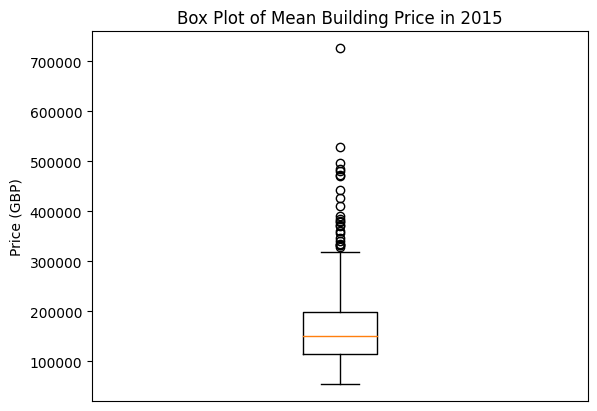

In [154]:
# Create a box plot for the column mean_15 to check potential outlier
plt.boxplot(data=gdf_joined, x='mean_15')

# Add title to the box plot
plt.title('Box Plot of Mean Building Price in 2015')

# Remove x-axis ticks and labels
plt.xticks([])

# Add y axis label
plt.ylabel('Price (GBP)')

<p align="justify"'> There is an outlier much higher than other buildings' price. It is not very likely that the mean building price in 2015 is higher than 700,000 GBP. To remove it, a threshold can be set. <p>

Text(0, 0.5, 'Price (GBP)')

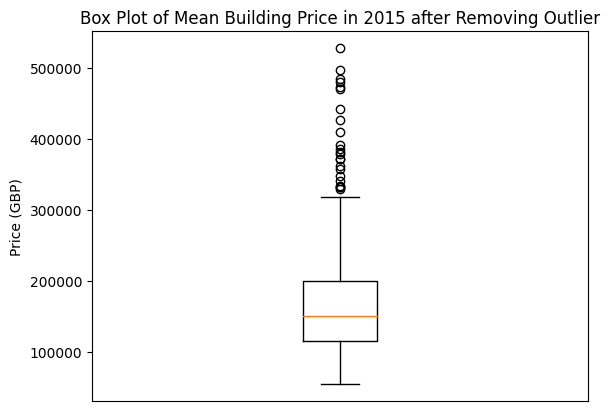

In [155]:
# Remove the outlier with a price higher than 700,000 GBP
gdf_cleaned = gdf_joined[gdf_joined['mean_15'] <= 700000]

# Check the result from box plot
plt.boxplot(data=gdf_cleaned, x='mean_15')

# Add title to the plot
plt.title('Box Plot of Mean Building Price in 2015 after Removing Outlier')

# Remove x-axis ticks and labels
plt.xticks([])

# Add a label to the y axis
plt.ylabel('Price (GBP)')

<p align="justify"'> From the box plot above, we found that the outlier is successfully removed.</p>

<p align="justify"'> Let's check if the CRS of the geodataframe is suitable for the spatial extent of UK.</p>

In [156]:
# Inspect the crs of the gdf
gdf_cleaned.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

<p align="justify"'> Last time check the information of the cleaned geodataframe to see whether there are null values and data type needs to be modified.</p>

In [157]:
# Check the cleaned dataframe
gdf_cleaned.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 480 entries, 0 to 480
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   AREA_CODE        480 non-null    object  
 1   AREA_NAME        480 non-null    object  
 2   MODE1_TYPE       480 non-null    object  
 3   MODE1_PC         480 non-null    float64 
 4   BP_PRE_1900_PC   480 non-null    float64 
 5   BP_1900_1918_PC  480 non-null    float64 
 6   BP_1919_1929_PC  480 non-null    float64 
 7   BP_1930_1939_PC  480 non-null    float64 
 8   BP_1945_1954_PC  480 non-null    float64 
 9   BP_1955_1964_PC  480 non-null    float64 
 10  BP_1965_1972_PC  480 non-null    float64 
 11  BP_1973_1982_PC  480 non-null    float64 
 12  BP_1983_1992_PC  480 non-null    float64 
 13  BP_1993_1999_PC  480 non-null    float64 
 14  BP_2000_2009_PC  480 non-null    float64 
 15  BP_2010_2015_PC  480 non-null    float64 
 16  mean_15          480 non-null    float64 

<p align="justify"'>All the variable names are meaningful and readable. The data types of all variables are good. There is no null value. The gdf_cleaned is ready for use.</p>

<p align="justify"'> A new gdf needs to be created to contain the centroids of the polygons in the gdf_cleaned since the centroids geometry will be used for the spatial visualization of building price. <p>

In [158]:
# Create a new gdf to contain the building price an the geometry
gdf_centroid = gdf_cleaned[['mean_15', 'geometry']]

# Calculate the centroids and update the geometry column with it
gdf_centroid['geometry'] = gdf_centroid.centroid

# Inspect the gdf_centroid
gdf_centroid.head()

,mean_15,geometry
0,218562.50,POINT (440160.258 449269.407)
1,242375.00,POINT (439887.841 449524.049)
2,301743.75,POINT (439968.218 448895.204)
3,497118.75,POINT (439278.732 447757.147)
4,385000.00,POINT (439117.870 448525.083)


# **Multiple Linear Regression Model**



<p align="justify"'> Multiple linear regression model refers to a multivariate model which use multiple explanatory variables (x1,x2,....,xp) to predict a response variable (y) <a href="https://hummedia.manchester.ac.uk/institutes/cmist/archive-publications/working-papers/2020/multiple-linear-regression.pdf#page=5.09">[4]</a>. A multiple linear regression model can be applied to check if there is a relationship between the building ages and building price in Leeds after the data cleaning is finished. For the multiple linear regression model, the independent variables are the columns from 'BP_PRE_1900_PC' to 'BP_2010_2015_PC' and the dependent variable is the 'mean_15' which is the mean building price in 2015. To get the best-fit model, a K-fold cross validation method is used. The k-fold cross validation split the dataset into k consecutive folds and each fold is used once as the validation dataset while the rest k-1 folds are used as the training dataset <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html">[5]</a>.

In [159]:
# Define the independent variables (X) and the dependent variable (y)
X = gdf_cleaned.iloc[:, 3:15] #select columns of percentage of model building ages
y = gdf_cleaned['mean_15'] # select column of building price

In [160]:
# Define the number of folds
k = 10

# Define the model we are going to use
model = LinearRegression()

# Define the cross-validation method
kf = KFold(n_splits=k, shuffle=True, random_state=40)

# Perform cross-validation
cv_results = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')

# Convert negative mean squared error to positive
mse_scores = -cv_results

# Calculate R-squared for each fold
r_squared_scores = cross_val_score(model, X, y, cv=kf)

# Calculate the coefficients and intercepts for each fold
coefficients = [] # create empyty list to store coefficients
intercepts = [] # create empyty list to store intercepts
for train_index, test_index in kf.split(X):
    #create training data and testing data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train) # use training data to train the model
    coefficients.append(model.coef_) # add coefficent to the list coefficients just created
    intercepts.append(model.intercept_) # add intercept to the list intercepts just created

# Calculate p-values for each coefficient
from scipy.stats import t
p_values = [] # an empty list to store the p values
n = len(X) # calculate the length of the X data
for coef, mse in zip(coefficients, mse_scores):
    dof = n - len(coef) - 1  # Degrees of freedom
    t_values = coef / np.sqrt(mse / n)  # t-values
    p_values.append([2 * (1 - t.cdf(np.abs(t_val), df=dof)) for t_val in t_values])  # two-sided p-values

# Combine coefficients, intercepts, p-values, and model fit statistics into a DataFrame
results_df = pd.DataFrame({
    'Coefficients': coefficients,
    'Intercepts': intercepts,
    'P-Values': p_values,
    'RMSE': np.sqrt(mse_scores),
    'R-squared': r_squared_scores
})

# Inspect the results_df
results_df.head(10)

,Coefficients,Intercepts,P-Values,RMSE,R-squared
0,"[-101743.13941093053, -81.49322123066258, -100...",206460.742667,"[0.0, 0.9829821515415365, 0.7923279336579585, ...",83658.867998,0.157899
1,"[-123635.49922698102, 24.472548899209926, -799...",201174.026698,"[0.0, 0.9918672121259962, 0.7392610346185489, ...",52572.714806,0.015768
2,"[-101299.82913693869, -224.69676217577882, -10...",212100.771998,"[0.0, 0.9255943712215207, 0.6729365381432362, ...",52684.912498,0.203149
3,"[-105986.6672398441, -28.19497520792754, -865....",196130.521863,"[0.0, 0.9945971966114076, 0.8353632038470575, ...",91175.344415,0.092016
4,"[-109254.36413930621, -129.22930969666936, -90...",207183.577088,"[0.0, 0.9626241880991326, 0.7419466072153524, ...",60386.400500,0.063777
5,"[-88106.34657235899, -61.42959951835411, -978....",195006.430875,"[0.0, 0.9872080022908634, 0.7983579776342968, ...",83897.464032,0.178570
6,"[-114871.40224669692, 6.82089469505938, -946.5...",201621.226786,"[0.0, 0.9986514692841335, 0.8145632196084356, ...",88370.738222,0.106986
7,"[-119203.91449564885, -80.91294316683678, -847...",210318.884985,"[0.0, 0.9784914153487017, 0.7777006551989292, ...",65717.582055,-0.078009
8,"[-118636.0522745497, 38.062082570541975, -640....",185970.238110,"[0.0, 0.9914993561738543, 0.857753100783412, 0...",78227.720132,-0.155770
9,"[-102242.72737336624, 172.32240650520782, -648...",173439.055820,"[0.0, 0.9579475918301963, 0.842631780148341, 0...",71561.133048,0.174855


<p align="justify"'> The statistical results of the 10 models created by K-fold cross validation are shown in the dataframe 'results_df' above. we found that the p-values of all the building ages are larger than 0.05 which means that none of the independent variables in the models is statistically important. The RMSE(Root Mean Squared Error) is very larger; besides, the R-squared is very close to 0 which denotes that the 10 multiple linear regression models do not fit the data at all. The research conclusion is that there is no relationship between the building age and building price in Leeds. </p>

<p align="justify"'>To improve this analysis, other variables and other models can be introduced. For example, the living space and distance to city center, which are two commonest variables, can be introduced to evaluate what is the driving factors of building price. Moreover, a multivariate polynomial regression model can be applied to replace the multiple linear regression model. Since the statistical outputs prove that a simple linear regression model does not fit the data, a polynominal model maybe helpful to capture more complex relationship in our data.
</p>

# **Visualization**

Data Visualisation
- Don't forget to present your final two data visualisation (one spatial and one non-spatial) and the justifications about the decisions you made whilst preparing and visualising the data.

Justification about preparing the data:

<p align="justify"'> In this project, we totally use three dataset including the building ages dataset, building price dataset, and the LSOA boundaries geojson. Since the LSOA updates every 10 years, we select the geojson of LSOA published in 2011. The purpose of the data preparation is to merge the 3 datasets into one geodataframe to only contain the information we need in a correct format.</p>
<p align="justify"'> For the building price dataset, we calculated the mean building price of 2015 by using the its building in 4 quarters. Then we remove all the unwanted columns and only keep the column of lsoa code and the calculated mean building price in 2015.</p>
<p align="justify"'> For the building age dataset, it contains the number of building with different building ages in each LSOA. We first calculated the the percentage of each building ages within the same LSOA. In our dataset, there are totally 13 types of different building ages, so 13 new columns are created. Next, we filter the dataframe by seleting the rows containing string "Leeds" in the column "AREA_NAME". Then only the columns of LSOA code, the percentage of each building age, the mode of the building age, and the percentage of the mode type of the building age are kept.</p>
<p align="justify"'> As for the geojson of Leeds, we only keep the column LSOA code and the its geometry.
<p align="justify"'> Since the dataframes building price, dataframes building age, and the gdf of Leeds have the LSOA column code, the three dataframes are joined together by using the LSOA code. Next, we remove the repeated column LSOA code in the joined dataframe and covert it to a geodataframe.</p>
<p align="justify"'> To detect outliers in the gdf, a box plot is created to show the distribution of building price. In the box plot, the building price of one LSOA is much higher than others. Therefore, it is removed by setting a threshold 700,000 GBP.Besides, the coordinate system of the gdf is check to be British National Grid. The info of the gdf is checked to ensure there is no null value and all the data type are good to use.</p>
<p align="justify"'> Finally, a new gdf is created by the function centroid() to contain the geometry information of the centroid of each LSOA polygon. This centroid gdf will be used in the visualization part.</p>

<p align="justify"'> First, the non-spatial visualization will display the mode of building ages versus the building price. <p>

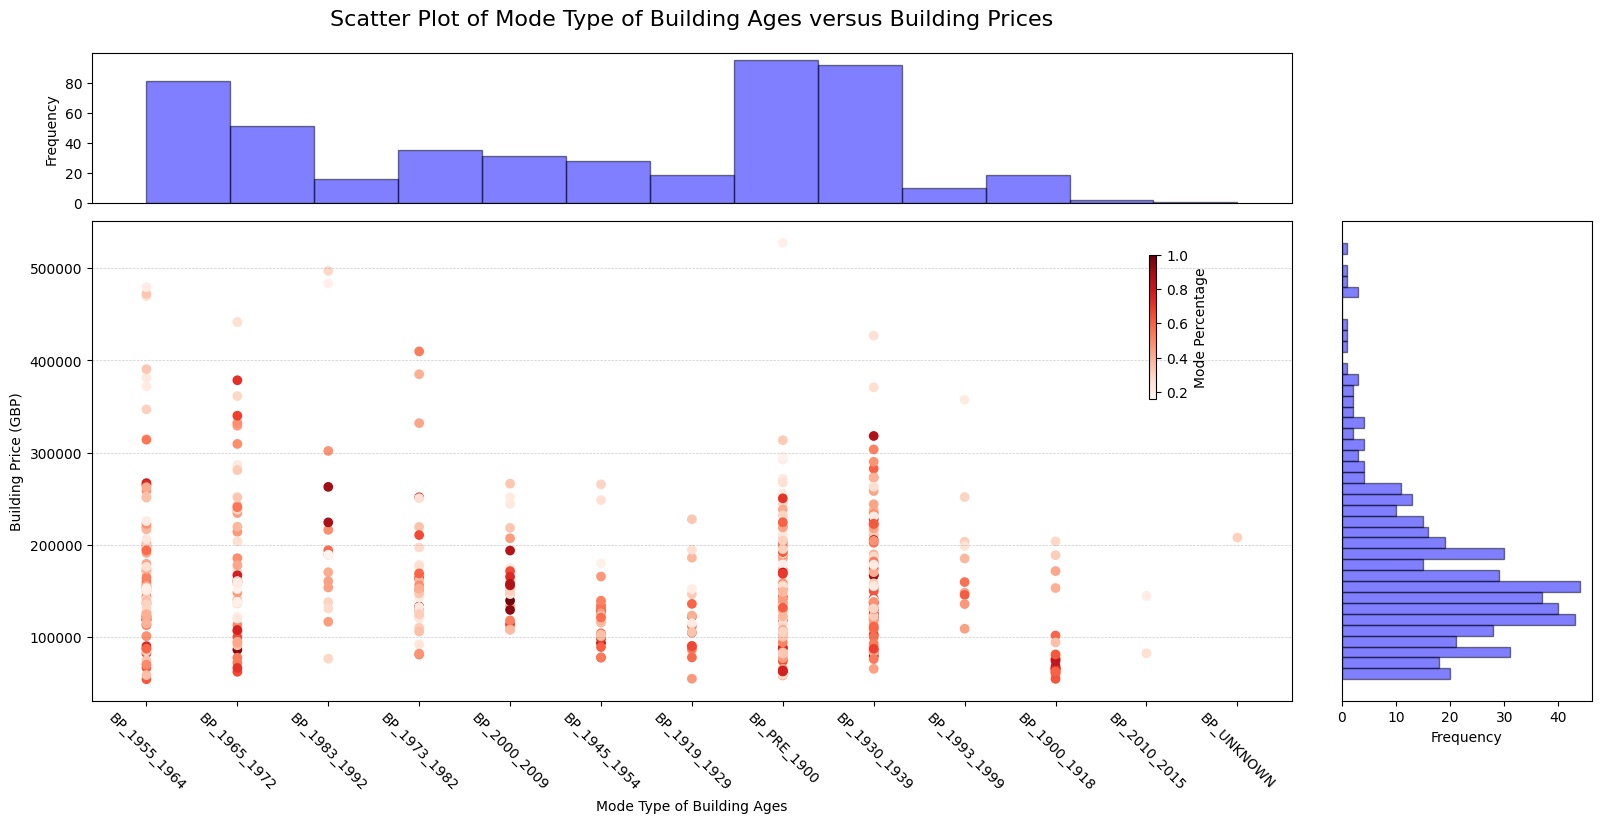

In [161]:
# Create your scatter plot
plt.figure(figsize=(25, 6))
# Define a 4x4 grid as the layout to contain subplots
gs = plt.GridSpec(4, 4)

# Define the location and size of each subplot
ax_main = plt.axes([0.1, 0.1, 0.6, 0.8])  # Main plot (left, bottom, width, height)
ax_hist_x = plt.axes([0.1, 0.93, 0.48, 0.25])  # Top histogram
ax_hist_y = plt.axes([0.6, 0.1, 0.1, 0.8])  # Right histogram

# Create the Scatter plot to show mode of building age and building price in 2015 with percentage of mode as the third variable
scatter = ax_main.scatter(x=gdf_cleaned['MODE1_TYPE'], y=gdf_cleaned['mean_15'], c=gdf_cleaned['MODE1_PC'], cmap='Reds')

# Rotate x-axis labels
ax_main.set_xticklabels(ax_main.get_xticklabels(), rotation=-45)

# Add x axis name for the scatter plot
ax_main.set_xlabel('Mode Type of Building Ages')
# Add y axis name for the scatter plot
ax_main.set_ylabel('Building Price (GBP)')

# Add grid line to the y axis
ax_main.grid(axis='y', linestyle='--', alpha=0.4, color='gray', linewidth=0.5)

# Add a title to the scatter plot
ax_main.set_title('Scatter Plot of Mode Type of Building Ages versus Building Prices', fontsize=16, pad=490, y=-0.01)

# Histogram for mode type of building ages
ax_hist_x.hist(gdf_cleaned['MODE1_TYPE'], bins=13, color='blue', alpha=0.5, edgecolor='black')
# Add x axis label to the histogram ax_hist_x
ax_hist_x.set_ylabel('Frequency')

# Histogram for building prices
ax_hist_y.hist(gdf_cleaned['mean_15'], bins=40, color='blue', alpha=0.5, orientation='horizontal', edgecolor='black')
# Add y axis label to the higtogram ax_hist_y
ax_hist_y.set_xlabel('Frequency')

# Remove ticks of histograms
ax_hist_x.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax_hist_y.tick_params(axis='y', which='both', left=False, labelleft=False)

# Add colorbar for the scatter plot
plt.colorbar(scatter, label='Mode Percentage',shrink=0.3, anchor=(-1.0, 0.9))

plt.show()

<p align="justify"'>In the non-spatial plot above, we try to visualize the relationship between the building price and the building age. The potential audience of this plot is the academic researchers who are interested in the relationship between building price and building ages in Leeds and people who want to buy a house in Leeds; besides, the policy makers can use this plot as a reference to determine wheather they need to introduce new policies to regulate the house market.</p>
<p align="justify"'>As for the visualization choice, we fist define the figure size as 25:6 to ensure the plot is large enough to read easily. Next, the layout of the plot is divided to a 4X4 gird to contain the subplots. To make sure the subplots are displayed in correct position, we give the subplots their variable names and define their locations.</p>
<p align="justify"'>The first subplot called ax_main is created to display mean builidng price in 2015 and the mode type of building age with the mode percentage as the thrid variable. The third variable "mode percentage" is used to show the degree to which the mode is proportional to the age of the building. Then the labels of the x ticks are rotated 45 degree to avoid the labels become crowded. Next, we add names to the x and y axis to show the variable names. A grid line is added for the y axis to help visualize the building price; besides, the style of the grid line is changed to dashed lines in grey with 0.4 scale and 0.5 linewidth. Also, a title is added to show the content of the plot. The font size of the title is set to 16 to make it more readable and its position is adjusted to the top of the subplot "ax_hist_x". Last, a color bar is added as the legend of the plot "ax_man". We modify its parameter to shrink the size of the colour bar to make it fit the extent of plot and change its position of the top-right corner.</p>
<p align="justify"'> For the subplot "ax_hist_x", it shows the frequency of the mode type of building ages. We set 13 bins for the histogram because totally there are 13 classes of building ages. For the subplot "ax_hist_y", it shows the frequency of the building price. We set 40 bins for the histogram to show as more variations as possible. Besides, the orentation of the histogram "ax_hist_y" is set to horizontal and it is adjusted to the right side of the scatter plot. For both of the histogram, the outline colour of the bins are set to black to highlight the boundary of the bins.</p>
<p align="justify"'> The colour of the scatter plot is set to red. The colour of the two histograms are set to blue. The reason is that red and blue not only have good contrast but also is color blindness friendly. Red-green, and blue-yellow are two most common types of colour blindness; besides, a red-blue colour palette is safe choice for colour blindness <a href="http://www.davidmathlogic.com/colorblind/">[6]</a>.</p>
<p align="justify"'>As the discussion under the part of the multiple linear regression model, we found that there is no apparent relationship between the buidling price and building age. It is not possible to observe a trend line from the plot. Beside, the building price even varies significantly within the same building age.</p>

Next, the spatial visualization will be displayed.

In [162]:
print(gdf_cleaned.crs)

EPSG:27700


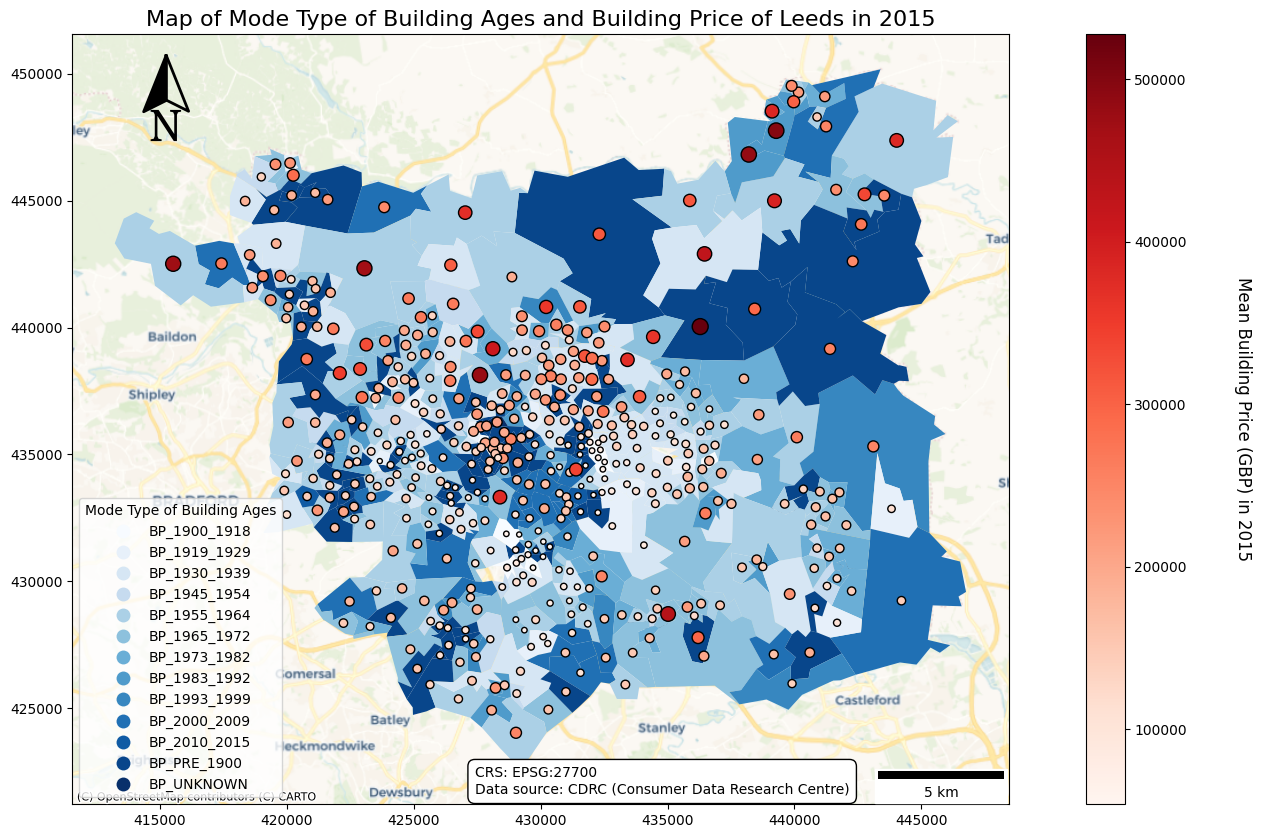

In [166]:
# Define the figure size
f, ax = plt.subplots(1, figsize=(20, 10))

# Plot the mode of building ages as a classified map
layer1 = gdf_cleaned.plot(ax=ax, column='MODE1_TYPE', cmap='Blues', legend=True)

# Add a legend title for layer 1
ax.get_legend().set_title('Mode Type of Building Ages')

# Plot graduated symbols based on the size variable
layer2 = gdf_centroid.plot(ax=ax, cmap='Reds', column='mean_15', edgecolor='k', marker='o', markersize=gdf_cleaned['mean_15']/4000, legend=True)

# Add a custom label for the legend title of layer2
plt.text(1.25, 0.5, 'Mean Building Price (GBP) in 2015', transform=ax.transAxes, ha='center', va='center', fontsize=12, rotation=270)

# add ctx basemap to ax
ctx.add_basemap(ax, crs='epsg:27700', source=ctx.providers.CartoDB.Voyager)

# Add a north arrow
add_north_arrow(ax, scale=0.6, xlim_pos=0.1, ylim_pos=0.9, color='#000', text_scaler=4, text_yT=-1.25)

# Add a scale bar to the right bottom
scalebar = ScaleBar(1, location='lower right') # define scale bar location
ax.add_artist(scalebar) # add to map

# Define projection and data source labels
label_text = f"CRS: {gdf_cleaned.crs}\nData source: CDRC (Consumer Data Research Centre)"

# Add label box to show the projection and data source
plt.text(0.43, 0.01, label_text, transform=ax.transAxes, ha='left', va='bottom', fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Add a title
plt.title('Map of Mode Type of Building Ages and Building Price of Leeds in 2015', fontsize=16)

# show the map
plt.show()

<p align="justify"'> The map above shows the distribution of building price and mode type of building ages in Leeds 2015. The potential audience is public who are interested in buying a house in Leeds, or the academic researchers who want to explore the pattern of housing market.</p>
<p align="justify"'> As for the visualization choice, the size of the map is first set to 20:10 to make the plot large enough to show the details.</p>
<p align="justify"'>Then, we create the firt layer for the mode type of building ages to display it as a choropleth map with a blue colour palette. Besides, a title is added for the legend of building ages. To avoid overlapping with the map, the position of the legend is adjusted to the right-bottom corner.</p>
<p align="justify"'>Next, the variable building price is added to the map as graduated symbol.The color of the symbol is set to red because red-blue if friendly for colour blindness. Then, we define the circle as the shape of the symbol and set its edge colour to black to make it more clear. To avoid the symbol becomes too large, the building price is divided by 4000 before it is set to the marker size. Also, a color bar is added to the right side of the map as a legend. The label is added next to the map to show what it represents.</p>
<p align="justify"'> To make the map more professional, some basic map elements are added to the map. A basemap is added by using the Python library contextily. A north arrow is added top-left corner by using a external library from github <a href="https://github.com/pmdscully/geo_northarrow">[7]</a>. Besides, a scale bar is added to the right-bottom corner. A label is added next to the scale bar to display the coordinate system EPSG27700 and the data source of the map. The make the label distinguishable from the base map, we set the background colour to white and set the outline color of the label box to black. Last, a title is added to show the topic of the map.</p>
<p align="justify"'> As the conclusion above, we cannot find a relationship between the building price and building age from the map as well. Some old buildings have large graduated symbols; however, some have small symbols. It is clear that building ages is not a driving factor of building price in Leeds.

## References
<p><a href="https://data.cdrc.ac.uk/dataset/dwelling-ages-and-prices#data-and-resources">[1]</a>CDRC. 2020. Dwelling Age Band Counts by LSOA (to 2015). *Consumer Data Research Centre*. [Online]. [Accessed 14 May 2024a]. Available from: https://data.cdrc.ac.uk/dataset/dwelling-ages-and-prices#data-and-resources.</p>

<p><a href="https://github.com/FrancescaPontin/GEOG5990">[2]</a>CDRC. 2020. Median House Prices by LSOA (Quarters, 1995-2018). *Consumer Data Research Centre*. [Online]. [Accessed 14 May 2024a]. Available from: https://data.cdrc.ac.uk/dataset/dwelling-ages-and-prices#data-and-resources.</p>

<p><a href="https://geoportal.statistics.gov.uk/datasets/f23b8af6504640558a5100dfcd19a7ee_0/explore?location=52.619015%2C-2.489798%2C6.97">[3]</a>ONS Geography. 2023. Lower layer super output areas (December 2011) boundaries EW BSC V4. *Open Geography portalx*. [Online]. [Accessed 14 May 2024d]. Available from: https://geoportal.statistics.gov.uk/datasets/f23b8af6504640558a5100dfcd19a7ee_0/explore?location=52.619015%2C-2.489798%2C6.97.</p>

<p><a href="https://hummedia.manchester.ac.uk/institutes/cmist/archive-publications/working-papers/2020/multiple-linear-regression.pdf#page=5.09">[4]</a>Tranmer, M., & Elliot, M. (2008). Multiple linear regression. The Cathie Marsh Centre for Census and Survey Research (CCSR), 5(5), 1-5.</p>

<p><a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html">[5]</a>scikit-learn scikit-learn documentation. (n.d.). sklearn.model_selection.KFold. [Online]. [Accessed 15 May 2024]. Available from: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html</p>

<p><a href="http://www.davidmathlogic.com/colorblind/">[6]</a>Nichols, D. n.d. Coloring for Colorblindness. Davidmathlogic.com. [Online]. [Accessed 16 May 2024]. Available from: http://www.davidmathlogic.com/colorblind/.</p>